# 🧠 CoAtNet Deepfake Detection Pipeline (UADFV video → frames → train)

This notebook extracts frames from your UADFV video dataset, builds a CoAtNet (Conv + Transformer) model,
creates dataloaders from extracted frames, and trains the model. The default is **20 frames per video**.

Replace the dataset paths if needed and run the cells sequentially.

In [ ]:
import os
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.optim import AdamW
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')


Using device: cpu


In [2]:
def extract_frames_from_videos(video_dir, output_dir, frames_per_video=20):
    os.makedirs(output_dir, exist_ok=True)
    classes = sorted([d for d in os.listdir(video_dir) if os.path.isdir(os.path.join(video_dir, d))])
    if not classes:
        raise RuntimeError(f"No class subfolders found in {video_dir}. Expected folders like 'Real' and 'Fake'.")
    total_videos = 0
    for cls in classes:
        class_path = os.path.join(video_dir, cls)
        out_class_dir = os.path.join(output_dir, cls)
        os.makedirs(out_class_dir, exist_ok=True)
        for fname in os.listdir(class_path):
            if not fname.lower().endswith(('.mp4', '.avi', '.mov', '.mkv')):
                continue
            total_videos += 1
            vid_path = os.path.join(class_path, fname)
            cap = cv2.VideoCapture(vid_path)
            if not cap.isOpened():
                print(f"Warning: couldn't open video {vid_path}")
                continue
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            if total_frames <= 0:
                cap.release()
                continue
            step = max(total_frames // frames_per_video, 1)
            frame_idxs = list(range(0, total_frames, step))[:frames_per_video]
            for i, idx in enumerate(frame_idxs):
                cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
                ret, frame = cap.read()
                if not ret:
                    continue
                fname_out = f"{os.path.splitext(fname)[0]}_frame{i:03d}.jpg"
                out_path = os.path.join(out_class_dir, fname_out)
                cv2.imwrite(out_path, frame)
            cap.release()
        print(f"Extracted frames for class '{cls}' to {out_class_dir}")
    print(f"Finished extracting frames from {total_videos} videos.")

In [3]:
def get_dataloaders(frames_dir, batch_size=16, img_size=224, val_split=0.2, augment=True):
    if augment:
        train_transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3)
        ])
    else:
        train_transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3)
        ])
    val_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])
    full_dataset = datasets.ImageFolder(frames_dir, transform=train_transform)
    if len(full_dataset) == 0:
        raise RuntimeError(f"No images found in {frames_dir}. Make sure frames were extracted and directory has class subfolders.")
    print(f"Found {len(full_dataset)} images across {len(full_dataset.classes)} classes: {full_dataset.classes}")
    val_size = int(len(full_dataset) * val_split)
    train_size = len(full_dataset) - val_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
    val_dataset.dataset.transform = val_transform
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    return train_loader, val_loader


In [4]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=3, stride=1):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size, stride, kernel_size // 2, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.SiLU(inplace=True)
        )
    def forward(self, x):
        return self.block(x)
    
class MBConv(nn.Module):
    def __init__(self, in_ch, out_ch, expansion=4, stride=1, drop_prob=0.2):
        super().__init__()
        hidden_dim = in_ch * expansion
        self.use_res = (in_ch == out_ch and stride == 1)
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, hidden_dim, 1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.SiLU(),
            nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.SiLU(),
            nn.Conv2d(hidden_dim, out_ch, 1, bias=False),
            nn.BatchNorm2d(out_ch),
        )
        self.dropout = nn.Dropout(drop_prob)
    def forward(self, x):
        out = self.block(x)
        if self.use_res:
            out = self.dropout(out)
            return x + out
        return out
    
class TransformerBlock(nn.Module):
    def __init__(self, dim, heads=8, mlp_ratio=4, drop_prob=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=heads, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim * mlp_ratio),
            nn.GELU(),
            nn.Dropout(drop_prob),
            nn.Linear(dim * mlp_ratio, dim)
        )
        self.dropout = nn.Dropout(drop_prob)
    def forward(self, x):
        B, C, H, W = x.shape
        x_flat = x.flatten(2).transpose(1, 2)  # [B, HW, C]
        x_attn = self.attn(self.norm1(x_flat), self.norm1(x_flat), self.norm1(x_flat))[0]
        x_flat = x_flat + self.dropout(x_attn)
        x_flat = x_flat + self.dropout(self.mlp(self.norm2(x_flat)))
        x = x_flat.transpose(1, 2).reshape(B, C, H, W)
        return x
    

In [5]:

class CoAtNet(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.stage1 = ConvBlock(3, 64, stride=2)
        self.stage2 = nn.Sequential(MBConv(64, 128, stride=2), MBConv(128, 128))
        self.stage3 = nn.Sequential(MBConv(128, 256, stride=2), MBConv(256, 256))
        self.stage4 = nn.Sequential(
            ConvBlock(256, 512, stride=1),
            TransformerBlock(512, heads=8),
            TransformerBlock(512, heads=8)
        )
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512, num_classes)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
    def forward(self, x):
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.pool(x).flatten(1)
        x = self.fc(x)
        return x

In [6]:
def train_model(model, train_loader, val_loader, device, epochs=10, lr=1e-4, save_path=None):
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0.0, 0, 0
        loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epochs}]")
        for imgs, labels in loop:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            loop.set_postfix(loss=total_loss / len(train_loader), acc=100.0 * correct / total)
        model.eval()
        val_correct, val_total, val_loss = 0, 0, 0.0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
        print(f"Epoch {epoch+1}/{epochs} - Train loss: {total_loss/len(train_loader):.4f} | Train acc: {100*correct/total:.2f}% | Val loss: {val_loss/len(val_loader):.4f} | Val acc: {100*val_correct/val_total:.2f}%")
    if save_path:
        torch.save(model.state_dict(), save_path)
        print(f"Model saved to {save_path}")


In [7]:
# ========== EVALUATION FUNCTIONS ==========
def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for imgs, labels in tqdm(test_loader, desc="Evaluating"):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            probs = F.softmax(outputs, dim=1)
            preds = outputs.argmax(dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels), np.array(all_probs)

def print_performance_metrics(y_true, y_pred, y_probs, class_names=None):
    if class_names is None:
        class_names = ['Class 0', 'Class 1']
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    if len(np.unique(y_true)) == 2:
        roc_auc = roc_auc_score(y_true, y_probs[:, 1])
    else:
        roc_auc = roc_auc_score(y_true, y_probs, multi_class='ovr')
    
    print("PERFORMANCE METRICS")
    print("=" * 50)
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"ROC AUC:   {roc_auc:.4f}")
    print("\n" + "=" * 50)
    print("CLASSIFICATION REPORT:")
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))
    
    return accuracy, precision, recall, f1, roc_auc

def plot_confusion_matrix(y_true, y_pred, class_names=None):
    if class_names is None:
        class_names = ['Real', 'Fake']
    
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()
    
    print("CONFUSION MATRIX DETAILS:")
    print(f"True Negatives (Real correctly classified): {cm[0, 0]}")
    print(f"False Positives (Real misclassified as Fake): {cm[0, 1]}")
    print(f"False Negatives (Fake misclassified as Real): {cm[1, 0]}")
    print(f"True Positives (Fake correctly classified): {cm[1, 1]}")

def plot_roc_curve(y_true, y_probs, class_names=None):
    if class_names is None:
        class_names = ['Real', 'Fake']
    
    if len(np.unique(y_true)) == 2:
        fpr, tpr, _ = roc_curve(y_true, y_probs[:, 1])
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

def comprehensive_evaluation(model, val_loader, device, class_names=None):
    if class_names is None:
        class_names = ['Real', 'Fake']
    
    print("STARTING COMPREHENSIVE EVALUATION...")
    print("=" * 60)
    
    y_pred, y_true, y_probs = evaluate_model(model, val_loader, device)
    accuracy, precision, recall, f1, roc_auc = print_performance_metrics(y_true, y_pred, y_probs, class_names)
    plot_confusion_matrix(y_true, y_pred, class_names)
    plot_roc_curve(y_true, y_probs, class_names)
    
    metrics = {
        'accuracy': accuracy, 'precision': precision, 'recall': recall, 
        'f1_score': f1, 'roc_auc': roc_auc, 'predictions': y_pred, 
        'true_labels': y_true, 'probabilities': y_probs
    }
    
    return metrics

Frames folder already exists — skipping extraction
Found 1960 images across 2 classes: ['fake', 'real']
✅ Pre-trained model loaded successfully!
RUNNING COMPREHENSIVE EVALUATION ON VALIDATION SET...
STARTING COMPREHENSIVE EVALUATION...


Evaluating: 100%|██████████| 25/25 [00:31<00:00,  1.24s/it]

PERFORMANCE METRICS
Accuracy:  0.9796
Precision: 0.9796
Recall:    0.9796
F1-Score:  0.9796
ROC AUC:   0.9959

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

        Real       0.99      0.98      0.98       203
        Fake       0.97      0.98      0.98       189

    accuracy                           0.98       392
   macro avg       0.98      0.98      0.98       392
weighted avg       0.98      0.98      0.98       392



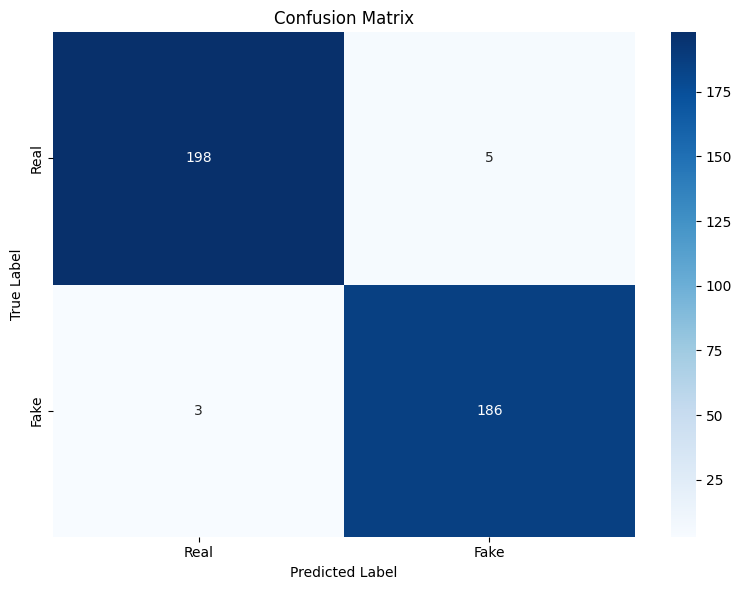

CONFUSION MATRIX DETAILS:
True Negatives (Real correctly classified): 198
False Positives (Real misclassified as Fake): 5
False Negatives (Fake misclassified as Real): 3
True Positives (Fake correctly classified): 186


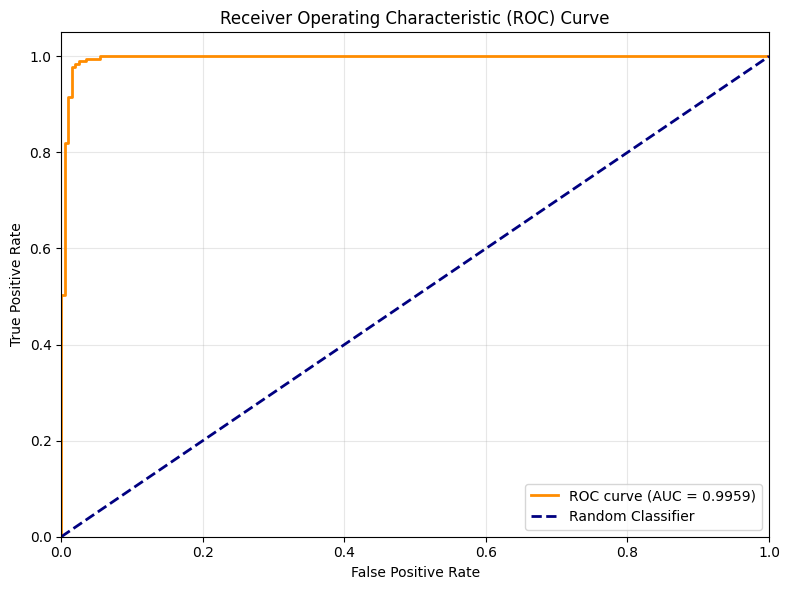

Evaluation completed successfully.


In [8]:
# ========== MAIN EXECUTION ==========
# Define your paths
VIDEO_DIR = r'C:\Users\rahul\Downloads\deepfake project\uadfv-new'
FRAMES_DIR = r'C:\Users\rahul\Downloads\deepfake project\uadfv-new-frames'

# 1. Extract frames if needed
if not os.path.exists(FRAMES_DIR) or not any(os.scandir(FRAMES_DIR)):
    print('Extracting frames from videos...')
    extract_frames_from_videos(VIDEO_DIR, FRAMES_DIR, frames_per_video=20)
else:
    print('Frames folder already exists — skipping extraction')

# 2. Create dataloaders
train_loader, val_loader = get_dataloaders(FRAMES_DIR, batch_size=16, img_size=224, val_split=0.2)

# 3. Create/Load model
model_path = os.path.join(os.getcwd(), 'coatnet_uadfv.pt')
if os.path.exists(model_path):
    # Load existing model
    model = CoAtNet(num_classes=2).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    print("✅ Pre-trained model loaded successfully!")
else:
    # Train new model
    print("No pre-trained model found. Training new model...")
    model = CoAtNet(num_classes=2).to(device)
    train_model(model, train_loader, val_loader, device, epochs=10, lr=1e-4, save_path=model_path)

# 4. Run comprehensive evaluation
print("RUNNING COMPREHENSIVE EVALUATION ON VALIDATION SET...")
metrics = comprehensive_evaluation(model, val_loader, device, class_names=['Real', 'Fake'])

print("Evaluation completed successfully.")